## Data preparation

In [10]:
# Standard library imports
import ast
import copy
import pickle
import random

# Related third-party imports
import pandas as pd
import torch
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T

pd.set_option('display.width', 1000)  # Set display width
pd.set_option('display.max_colwidth', 200)  # Set max column width to 100 characters
pd.set_option('display.max_rows', 100)

In [11]:
# List to hold data rows
data_list = []

with open('preprocessed_data.json', 'r') as f:
    # Read the first x lines
    for _ in range(100000):
        line = f.readline()
        if not line:  # Exit the loop if we reach end of file
            break
        data_list.append(eval(line))  # Convert the JSON line to a Python dict

# Convert list of dicts to a DataFrame
df = pd.DataFrame(data_list)

# Display the DataFrame (optional)
df.head(2)

,overall,verified,reviewerID,asin,reviewTime_year,reviewTime_month,reviewTime_day,num_reviews,avg_overall,summary_embedding,reviewText_embedding,reviewerName_embedding,price,title_embedding,brand_embedding,main_cat_embedding,feature_str_embedding
0,3.0,1,A11F6V4DD7WND4,0972970169,2008,1,7,5,4.0,"[-0.0349934027, 0.3010466993, 0.2923053205, -0.2102584094, -0.4241042137, -0.0882628933, -0.0622854941, 0.1726019382, 0.2244427502, -0.388314724, 0.2109862417, 0.5282078981, 0.7086040378, -0.29692...","[0.1435533613, 0.2974196076, 0.0406210013, 0.3089621663, -0.1878142804, 1.0334198475, 0.5054050088, -0.6605418921, 0.3008339703, 0.0249028914, 0.5751209259, 0.2520704865, 0.7460249662, 0.958773732...","[-0.018527884, -0.0252203979, 0.0289514419, -0.0192238018, -0.1012029648, -0.1017871425, 0.0602640063, 0.0942470729, 0.0256298799, -0.0573205054, -0.0439745374, -0.075106971, -0.0747173056, 0.0600...",24.95,"[0.4795634, 0.26978546, 0.41530558, 0.6573644, -0.057249546, -1.5672796, 1.0454497, 0.68714136, -0.91670555, -0.32354182, -1.4662147, -0.24356121, 0.74302655, 0.8804182, -0.47620353, 1.0890119, -0...","[-0.0077716955, 0.18858612, 0.036968283, -0.01429993, -0.2067404, -0.10090074, -0.22654955, 0.57370096, 0.14598724, -0.096954025, 0.20070614, 0.22820446, -0.17270273, 0.1784086, 0.6222673, -0.1147...","[0.0069790934, -0.0002095115, -0.00794701, 0.008890595, -0.008551635, 0.005559889, 0.0064678504, 0.0009757793, -0.008692562, 0.0061753215, -0.007847871, -0.005017768, 0.009624788, -0.008282142, -0...","[0.19309111, -0.45927882, -1.6106459, 0.6315689, -0.3419104, -0.020687653, -0.96790636, -0.061966542, -0.6577551, 0.1824594, 0.38663667, 0.31777436, 0.3076588, 0.87539667, 1.213906, 0.35560438, -0..."
1,5.0,0,AXPZYN4FP89L9,0972970169,2007,3,8,5,4.0,"[0.2521066368, -0.711258471, 0.2522184551, -0.3704526722, -0.2950870991, -0.5340000987, 0.3067598641, -0.0131782787, 0.1561563015, -0.1554050595, 0.0010164902, 0.2839199007, -0.2991110384, -0.1136...","[0.3085278571, -0.6354773641, 0.0227410644, 0.4703448117, 0.2965022624, 0.5948812962, 1.0992649794, 0.0630262047, 0.1848281622, 0.0367317833, 0.0199860055, -0.0617028251, 0.8646436334, 0.591421306...","[0.0892119333, 0.0176855735, 0.063613154, -0.0668008029, -0.0935918242, -0.1414932758, 0.0935875326, 0.075328663, 0.0550518669, -0.0814011469, 0.0007571077, -0.0971234664, 0.0071578929, -0.0061461...",24.95,"[0.4795634, 0.26978546, 0.41530558, 0.6573644, -0.057249546, -1.5672796, 1.0454497, 0.68714136, -0.91670555, -0.32354182, -1.4662147, -0.24356121, 0.74302655, 0.8804182, -0.47620353, 1.0890119, -0...","[-0.0077716955, 0.18858612, 0.036968283, -0.01429993, -0.2067404, -0.10090074, -0.22654955, 0.57370096, 0.14598724, -0.096954025, 0.20070614, 0.22820446, -0.17270273, 0.1784086, 0.6222673, -0.1147...","[0.0069790934, -0.0002095115, -0.00794701, 0.008890595, -0.008551635, 0.005559889, 0.0064678504, 0.0009757793, -0.008692562, 0.0061753215, -0.007847871, -0.005017768, 0.009624788, -0.008282142, -0...","[0.19309111, -0.45927882, -1.6106459, 0.6315689, -0.3419104, -0.020687653, -0.96790636, -0.061966542, -0.6577551, 0.1824594, 0.38663667, 0.31777436, 0.3076588, 0.87539667, 1.213906, 0.35560438, -0..."


In [47]:
df_10000=df.copy(deep=True)

In [12]:
# Select only the 'overall', 'reviewerID', and 'asin' columns for Collaborative filtering task
selected_df = df[['overall', 'reviewerID', 'asin']]

# Rename the columns as specified
renamed_df = selected_df.rename(columns={'overall': 'rating', 'reviewerID': 'userId', 'asin': 'productId'})

# Display the renamed DataFrame (optional)
renamed_df.head(3)

,rating,userId,productId
0,3.0,A11F6V4DD7WND4,0972970169
1,5.0,AXPZYN4FP89L9,0972970169
2,4.0,AOCT8ZWCRWLRE,0972970169


In [13]:
# Create a mapping for reviewer IDs to a range of unique consecutive integers.
# This process assigns each unique reviewer ID a distinct and consecutive integer ID.

# Step 1: Extract unique reviewer IDs from the DataFrame
unique_reviewer_id = df['reviewerID'].unique()

# Step 2: Create a new DataFrame with the original reviewer IDs and their mapped consecutive integers.
# 'pd.RangeIndex(len(unique_reviewer_id))' creates a range of integers from 0 to the number of unique reviewer IDs.
mapped_reviewer_id = pd.DataFrame(data={
    'reviewerID': unique_reviewer_id,
    'mappedID': pd.RangeIndex(len(unique_reviewer_id)),
})

# Print the first few rows of the mapping to verify
print("Mapping of reviewer IDs to consecutive values:")
print("==============================================")
print(mapped_reviewer_id.head())
print()

Mapping of reviewer IDs to consecutive values:
       reviewerID  mappedID
0  A11F6V4DD7WND4         0
1   AXPZYN4FP89L9         1
2   AOCT8ZWCRWLRE         2
3  A1UUD54HPAQZ2G         3
4  A2YHHBBJVTVD79         4



In [14]:
unique_product_id = df['asin'].unique()
mapped_product_id = pd.DataFrame(data={
    'asin': unique_product_id,
    'mappedID': pd.RangeIndex(len(unique_product_id)),
})

# Print the first few rows of the mapping to verify
print("Mapping of product IDs to consecutive values:")
print("=============================================")
print(mapped_product_id.head())
print()

Mapping of product IDs to consecutive values:
         asin  mappedID
0  0972970169         0
1  0982085028         1
2  1590651529         2
3  1590653289         3
4  1590651669         4



In [15]:
#Preparing data for collaborative filtering task, using the same mapping as for GNN
# Map reviewer IDs to consecutive values
renamed_df['userId'] = renamed_df['userId'].map(mapped_reviewer_id.set_index('reviewerID')['mappedID'])

# Map product IDs to consecutive values
renamed_df['productId'] = renamed_df['productId'].map(mapped_product_id.set_index('asin')['mappedID'])

# Display the DataFrame with mapped values
print("DataFrame with mapped reviewer and product IDs:")
print("===============================================")
renamed_df.head(3)


DataFrame with mapped reviewer and product IDs:


,rating,userId,productId
0,3.0,0,0
1,5.0,1,0
2,4.0,2,0


In [16]:
#Prepared data for CF task
renamed_df.to_csv('ratings100000.csv', index=False)

In [17]:
# Saving the mappings to CSV
mapped_reviewer_id.to_csv('reviewer_mapping.csv', index=False)
mapped_product_id.to_csv('product_mapping.csv', index=False)

In [18]:
# The goal of this code is to merge the main DataFrame with the mapped ID DataFrames 
# to replace the original IDs with their mapped numeric counterparts.
# This is useful for converting string-based IDs to numeric IDs for processing.

# Merge the 'reviewerID' column from 'df' with 'unique_reviewer_id' to obtain numeric reviewer IDs
# This merge is done based on the 'reviewerID' column
reviews_reviewer_id = pd.merge(df['reviewerID'], mapped_reviewer_id,
                               left_on='reviewerID', right_on='reviewerID', how='left')
# Convert the resulting Series of mapped reviewer IDs to a PyTorch tensor
reviews_reviewer_id_tensor = torch.from_numpy(reviews_reviewer_id['mappedID'].values)

# Similarly, merge the 'asin' column from 'df' with 'unique_product_id' to obtain numeric product IDs
# This merge is based on the 'asin' column
ratings_product_id = pd.merge(df['asin'], mapped_product_id,
                              left_on='asin', right_on='asin', how='left')
# Convert the resulting Series of mapped product IDs to a PyTorch tensor
ratings_product_id_tensor = torch.from_numpy(ratings_product_id['mappedID'].values)

In [19]:
print(reviews_reviewer_id_tensor)
print(ratings_product_id_tensor)

tensor([    0,     1,     2,  ..., 49334, 49335, 49335])
tensor([  0,   0,   0,  ..., 772, 772, 772])


In [20]:
# The following code snippet constructs the edge index for a graph in COO format. 
# This format is commonly used in PyTorch Geometric (PyG) to represent graph edges.

# The 'reviews_reviewer_id_tensor' and 'ratings_product_id_tensor' tensors hold the numeric IDs for reviewers and products.
# These IDs are obtained from previous data processing steps where original string-based IDs were mapped to numeric values.

# Stack the reviewer and product tensors horizontally to create a 2D tensor.
# Each column in this tensor represents an edge in the graph, with the first row being the source (reviewer) and the second row the target (product).
edge_index_reviewer_to_product = torch.stack([reviews_reviewer_id_tensor, ratings_product_id_tensor], dim=0)

# Output the size of the edge_index tensor. This represents the total number of edges in the graph.
print("Size of edge_index_reviewer_to_product:", edge_index_reviewer_to_product.size())

# Store the number of edges in a variable for later assertion check.
edge_number = edge_index_reviewer_to_product.size()[1]
print(edge_number)

# Assert that the edge_index tensor is of the correct shape. 
# The first dimension should be 2 (for source and target), and the second dimension should be the number of edges.
assert edge_index_reviewer_to_product.size() == (2, edge_number)

# Output the final edge indices which represent connections from reviewers to products.
print("\nFinal edge indices pointing from reviewers to products:")
print("=================================================")
print(edge_index_reviewer_to_product)

Size of edge_index_reviewer_to_product: torch.Size([2, 100000])
100000

Final edge indices pointing from reviewers to products:
tensor([[    0,     1,     2,  ..., 49334, 49335, 49335],
        [    0,     0,     0,  ...,   772,   772,   772]])


In [61]:
data = HeteroData()
# Save node indices:
data["reviewer"].node_id = torch.arange(len(unique_reviewer_id))
data["product"].node_id = torch.arange(len(unique_product_id))

features = ['overall', 'verified', 'reviewTime_year', 'reviewTime_month','reviewTime_day',
            'summary_embedding', 'reviewText_embedding', 'reviewerName_embedding']

# Map reviewerID to its corresponding ID
reviewer_to_id = {reviewerID: idx for idx, reviewerID in enumerate(df['reviewerID'].unique())}
reviewer_indices = torch.tensor([reviewer_to_id[reviewerID] for reviewerID in df['reviewerID']], dtype=torch.long)

# Prepare the feature tensor for reviewers
feature_tensors = []
for feature in features:
    if df[feature].dtype == object:  # it's likely an embedding
        feature_tensor = torch.tensor(df[feature].tolist(), dtype=torch.float32)
    else:  # scalar feature
        feature_tensor = torch.tensor(df[feature].values, dtype=torch.float32).unsqueeze(1)
    feature_tensors.append(feature_tensor)

reviewer_features = torch.cat(feature_tensors, dim=1)

data['reviewer'].x = reviewer_features[reviewer_indices]

# Add the node features and edge indices:
# Assign node features for 'product' nodes
product_data = df.groupby('asin').agg({
    'overall': 'mean',
    'reviewerID': 'size',
    'title_embedding': 'first',         
    'brand_embedding': 'first',          
    'main_cat_embedding': 'first',       
    'feature_str_embedding': 'first'     
}).reset_index()
product_data.rename(columns={'overall': 'avg_overall', 'reviewerID': 'num_reviews'}, inplace=True)
# Create a dictionary to map asin to its corresponding ID
asin_to_id = {asin: idx for idx, asin in enumerate(df['asin'].unique())}

# Now use this dictionary to get the product indices
product_indices = torch.tensor([asin_to_id[asin] for asin in product_data['asin']], dtype=torch.long)
product_features_list = [
    torch.tensor(product_data[['avg_overall', 'num_reviews']].values, dtype=torch.float32),
    torch.tensor(product_data['title_embedding'].tolist(), dtype=torch.float32),
    torch.tensor(product_data['brand_embedding'].tolist(), dtype=torch.float32),
    torch.tensor(product_data['main_cat_embedding'].tolist(), dtype=torch.float32),
    torch.tensor(product_data['feature_str_embedding'].tolist(), dtype=torch.float32)
]
product_features = torch.cat(product_features_list, dim=1)[product_indices]
data['product'].x = product_features
data["reviewer", "reviews", "product"].edge_index = edge_index_reviewer_to_product
# We also need to make sure to add the reverse edges from movies to users
# in order to let a GNN be able to pass messages in both directions.
# We can leverage the `T.ToUndirected()` transform for this from PyG:
data = T.ToUndirected()(data)


In [55]:
with open('data10000.pkl', 'wb') as file:
    pickle.dump(data, file)

In [62]:
print(data)

HeteroData(
  reviewer={
    node_id=[49336],
    x=[100000, 305],
  },
  product={
    node_id=[773],
    x=[773, 402],
  },
  (reviewer, reviews, product)={ edge_index=[2, 100000] },
  (product, rev_reviews, reviewer)={ edge_index=[2, 100000] }
)


In [63]:
with open('data100000.pkl', 'wb') as file:
    pickle.dump(data, file)

In [ ]:
with open('data10000.pkl', 'rb') as file:
    data = pickle.load(file)

## Graph visualization

In [18]:
def hetero_to_networkx(data):
    G = nx.MultiDiGraph()

    # Adding nodes to the graph
    for node_type in data.node_types:
        ids = data[node_type].node_id
        G.add_nodes_from([(node_type + "_" + str(i.item()), {"type": node_type}) for i in ids])

    # Adding edges to the graph
    for (src_type, edge_type, dst_type), edge_index in data.edge_index_dict.items():
        edges = list(zip(edge_index[0].numpy(), edge_index[1].numpy()))
        G.add_edges_from([(src_type + "_" + str(src), dst_type + "_" + str(dst), {"type": edge_type}) for src, dst in edges])

    return G

In [53]:
def plot_product_subgraph(G, product_id):
    """
    Plot a subgraph centered on a specific product node.
    
    Parameters:
    - G: The main graph.
    - product_id: The ID of the product node around which the subgraph will be extracted.
    """
    # Extract the subgraph centered on the product node
    ego_graph = nx.ego_graph(G, "product_" + str(product_id), radius=1)
    
    plt.figure(figsize=(15, 15))
    pos = nx.spring_layout(ego_graph, k=0.5)

    color_map = {
        'reviewer': 'green',
        'product': 'blue'
    }

    # Draw nodes
    for node_type, color in color_map.items():
        nx.draw_networkx_nodes(ego_graph, pos, 
                               nodelist=[n for n, d in ego_graph.nodes(data=True) if d['type'] == node_type],
                               node_size=100,
                               node_color=color,
                               label=node_type)
    
    # Draw edges
    nx.draw_networkx_edges(ego_graph, pos, width=1.5, alpha=0.6)

    plt.title(f"Product ID: {product_id}")
    
    plt.legend()
    plt.axis("off")
    plt.tight_layout()
    plt.show()




In [78]:
def plot_reviewers_with_multiple_products(G, limit=None, min_products=4):
    """
    Plot subgraphs of reviewers who have bought a certain number of products or more.
    
    Parameters:
    - G: The main graph.
    - limit: Max number of reviewers to visualize. If None, all reviewers with the required number of products are visualized.
    - min_products: Minimum number of products a reviewer should be connected to.
    """
    # Find reviewers connected to more than 'min_products' product nodes
    reviewers_multiple_products = [node for node, adjacencies in G.adjacency() if node.startswith("reviewer_") and len(adjacencies) >= min_products]
    
    if limit:
        reviewers_multiple_products = random.sample(reviewers_multiple_products, min(limit, len(reviewers_multiple_products)))

    for reviewer in reviewers_multiple_products:
        # Extract the subgraph centered on the reviewer node
        ego_graph = nx.ego_graph(G, reviewer, radius=1)
        
        plt.figure(figsize=(15, 15))
        pos = nx.spring_layout(ego_graph, k=0.5)

        color_map = {
            'reviewer': 'green',
            'product': 'blue'
        }

        # Draw nodes
        for node_type, color in color_map.items():
            nx.draw_networkx_nodes(ego_graph, pos, 
                                   nodelist=[n for n, d in ego_graph.nodes(data=True) if d['type'] == node_type],
                                   node_size=100,
                                   node_color=color,
                                   label=node_type)
    
        # Draw edges
        nx.draw_networkx_edges(ego_graph, pos, width=1.5, alpha=0.6)
        
        # Draw labels for nodes
        labels = {node: node.split('_')[1] for node in ego_graph.nodes()}
        nx.draw_networkx_labels(ego_graph, pos, labels=labels, font_size=12, font_color='black')

        plt.title(f"Reviewer ID: {reviewer.split('_')[1]}")
    
        plt.legend()
        plt.axis("off")
        plt.tight_layout()
        plt.show()

In [50]:
def plot_reduced_graph(G, num_edges=300, save_path=None):
    """
    Plot a reduced graph focusing on a specific number of connections (edges).
    
    Args:
    - G (networkx.Graph): The input graph.
    - num_edges (int, optional): The number of edges to include in the visualization. Defaults to 200.
    
    Returns:
    None
    """
    
    plt.figure(figsize=(15, 15))
    
    # Convert edges to a list and then select a sample
    edges_list = list(G.edges())
    edges_sample = random.sample(edges_list, min(num_edges, len(edges_list)))
    nodes_in_sample = set([u for u, v in edges_sample] + [v for u, v in edges_sample])

    # Subset of the graph for visualization
    G_sample = G.subgraph(nodes_in_sample)
    pos = nx.spring_layout(G_sample, k=0.5)

    color_map = {
        'reviewer': 'green',
        'product': 'blue'
    }

    # Draw nodes
    for node_type, color in color_map.items():
        nx.draw_networkx_nodes(G_sample, pos, 
                               nodelist=[n for n, d in G_sample.nodes(data=True) if d['type'] == node_type],
                               node_size=100,
                               node_color=color,
                               label=node_type)

    # Draw only the sampled edges
    nx.draw_networkx_edges(G_sample, pos, 
                           edgelist=edges_sample,
                           width=1.5, alpha=0.6)

    plt.legend()
    plt.axis("off")
    if save_path:
        plt.savefig(save_path, dpi=100, compress_level=9)
    else:
        plt.show()




In [37]:
G = hetero_to_networkx(data)

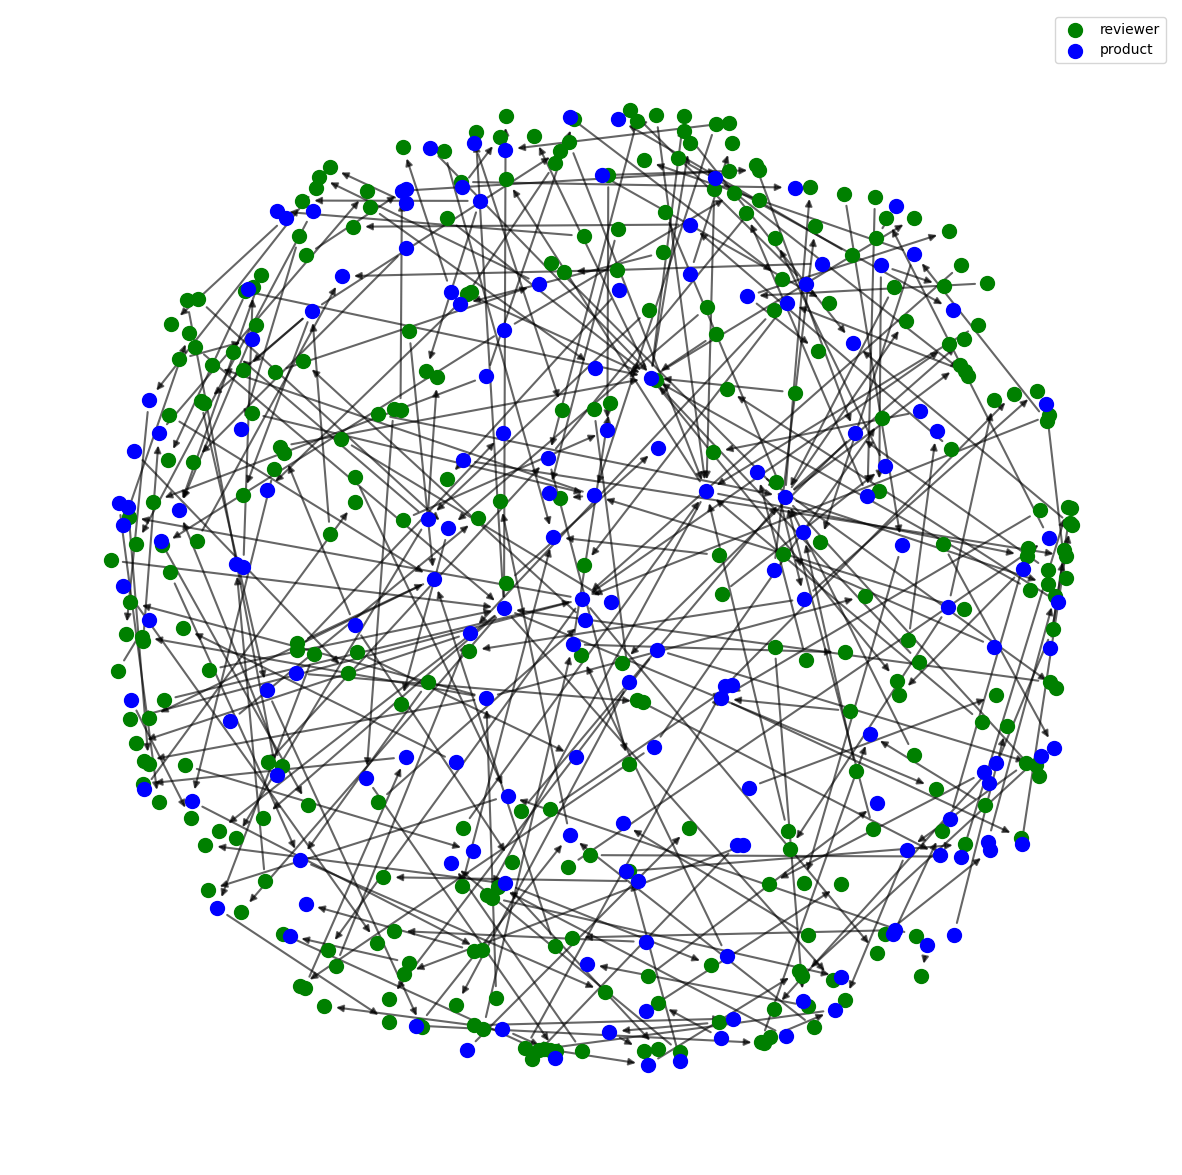

In [51]:
plot_reduced_graph(G)


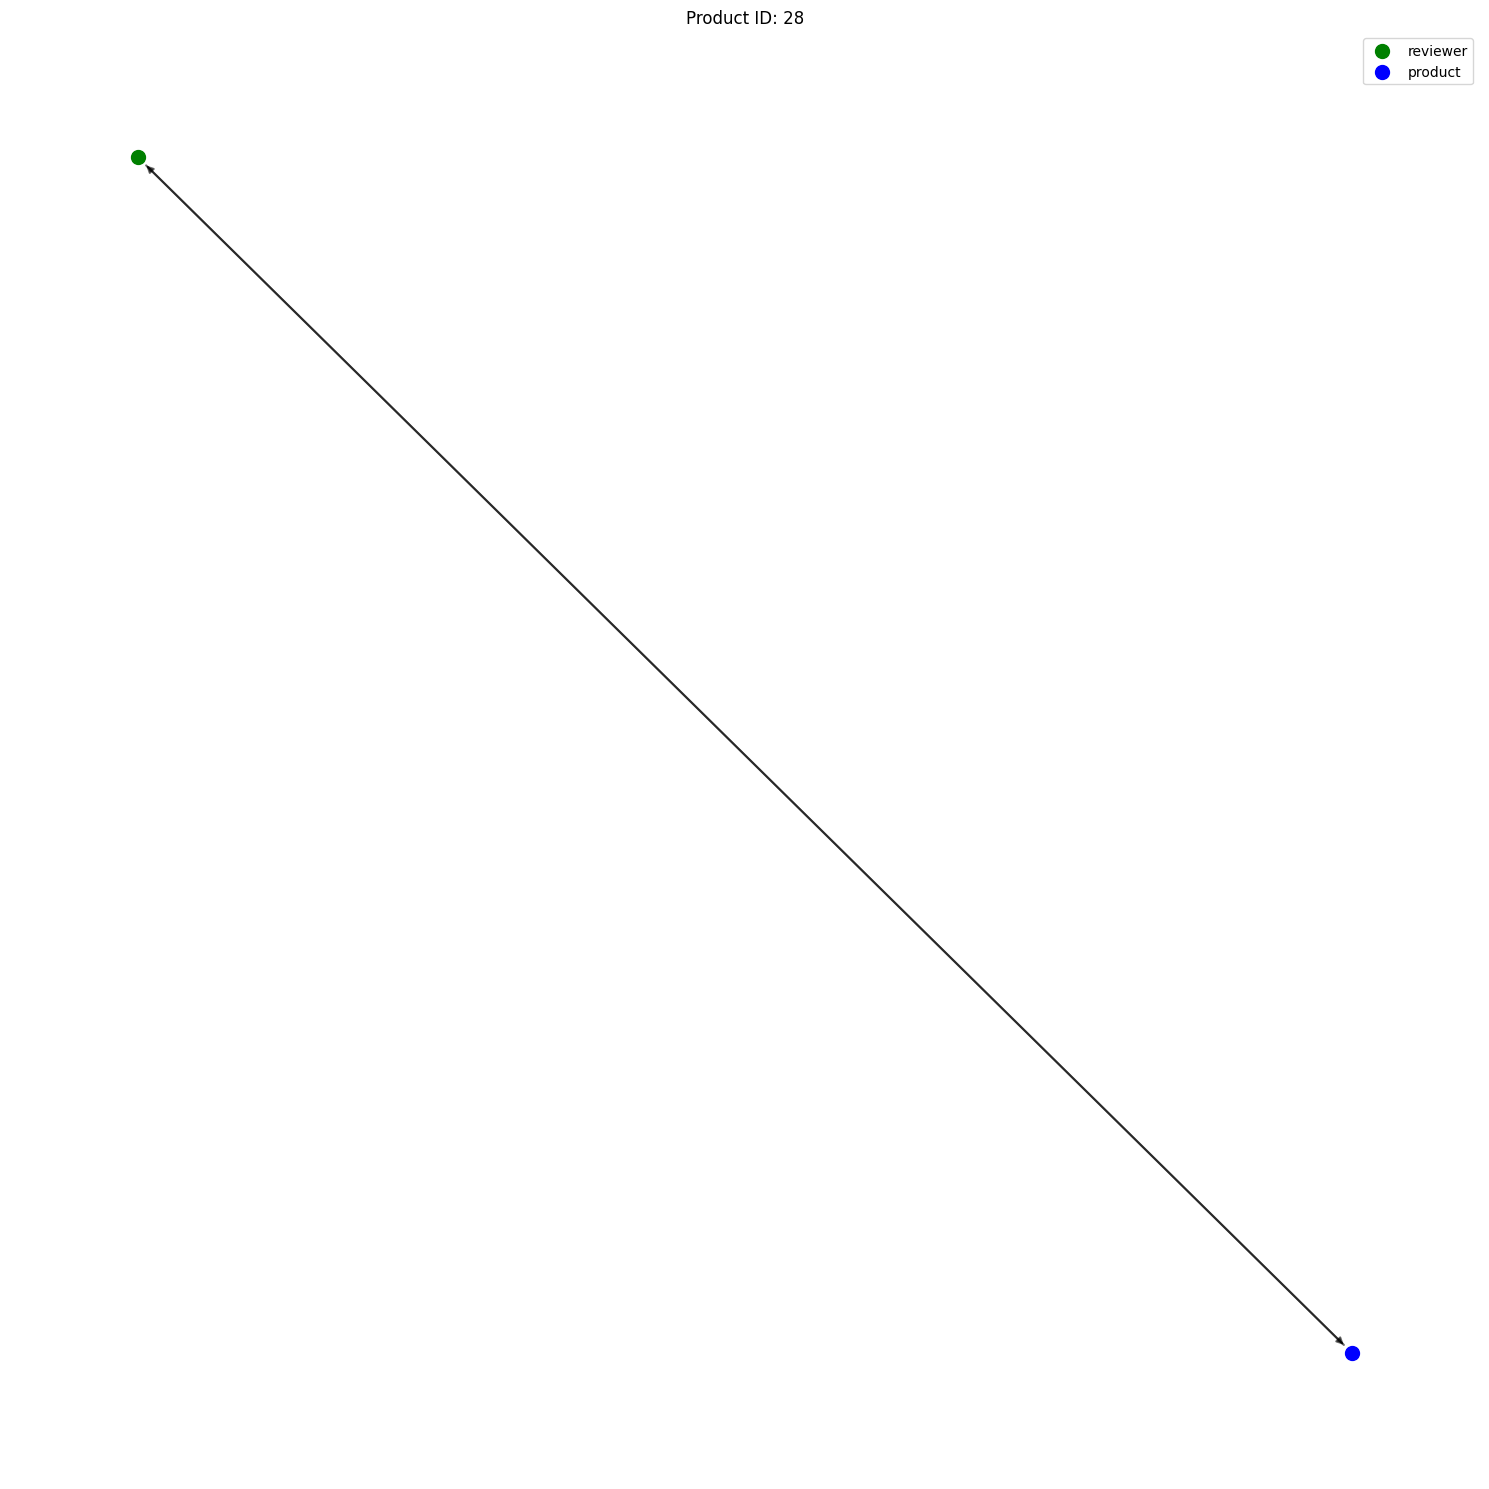

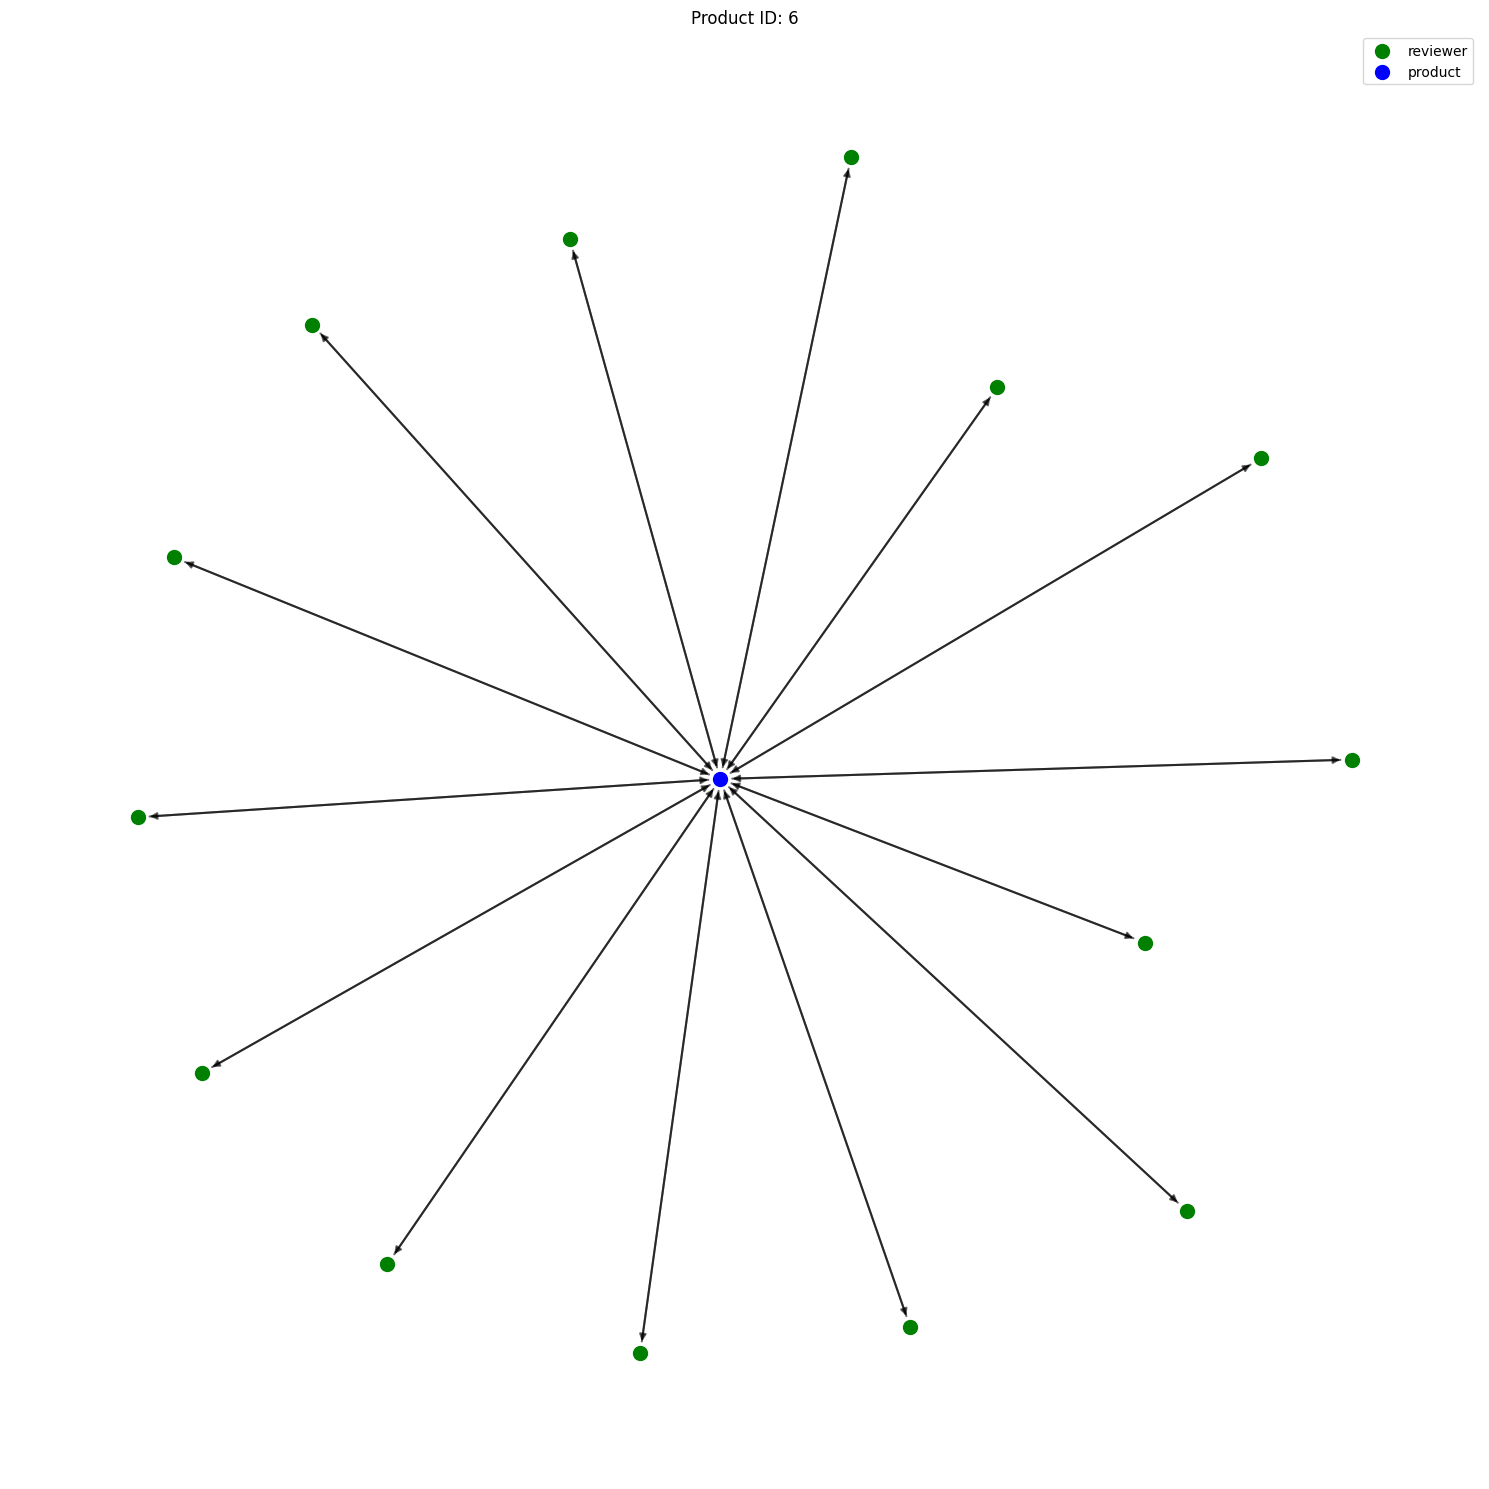

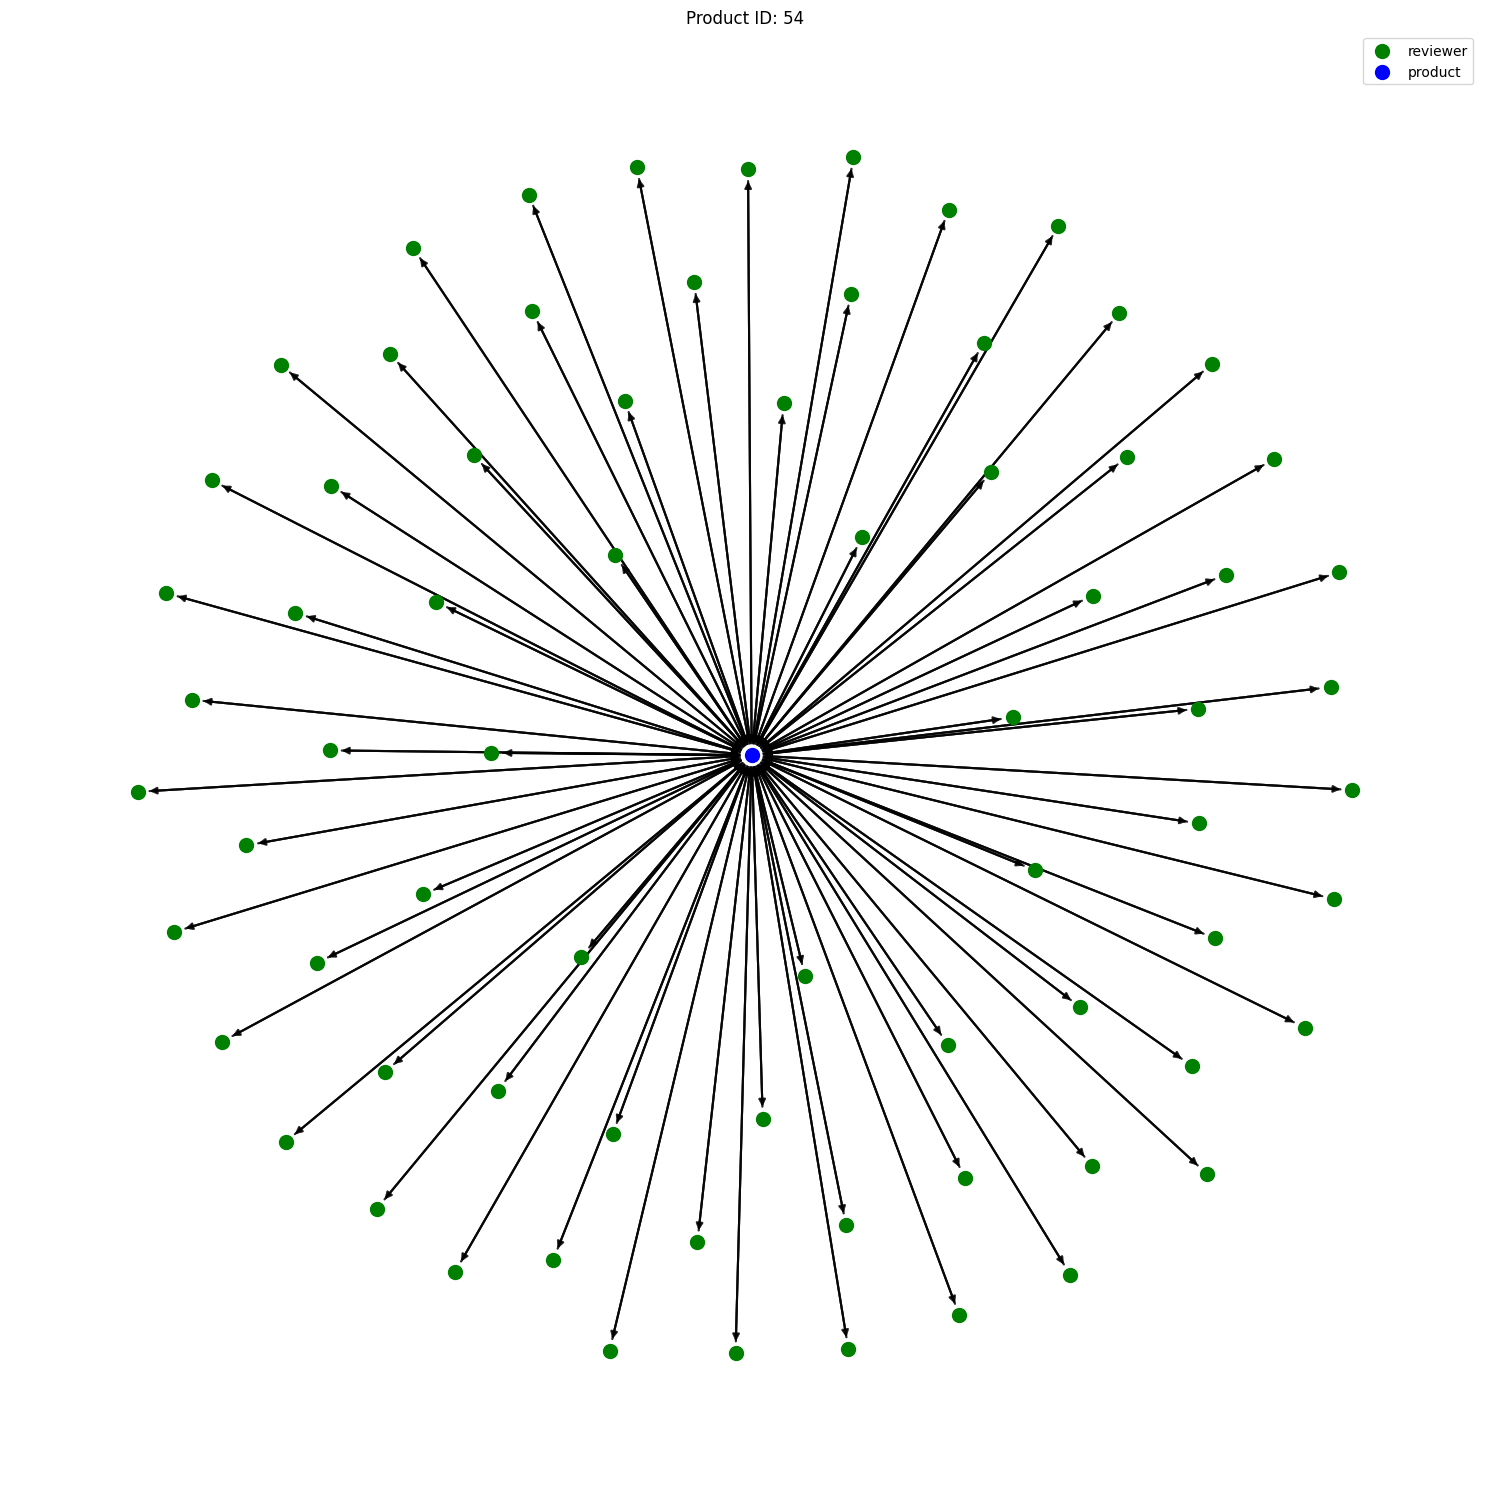

In [83]:
# List of product IDs you want to visualize
product_ids = [28, 6, 54]  

for product_id in product_ids:
    plot_product_subgraph(G, product_id)

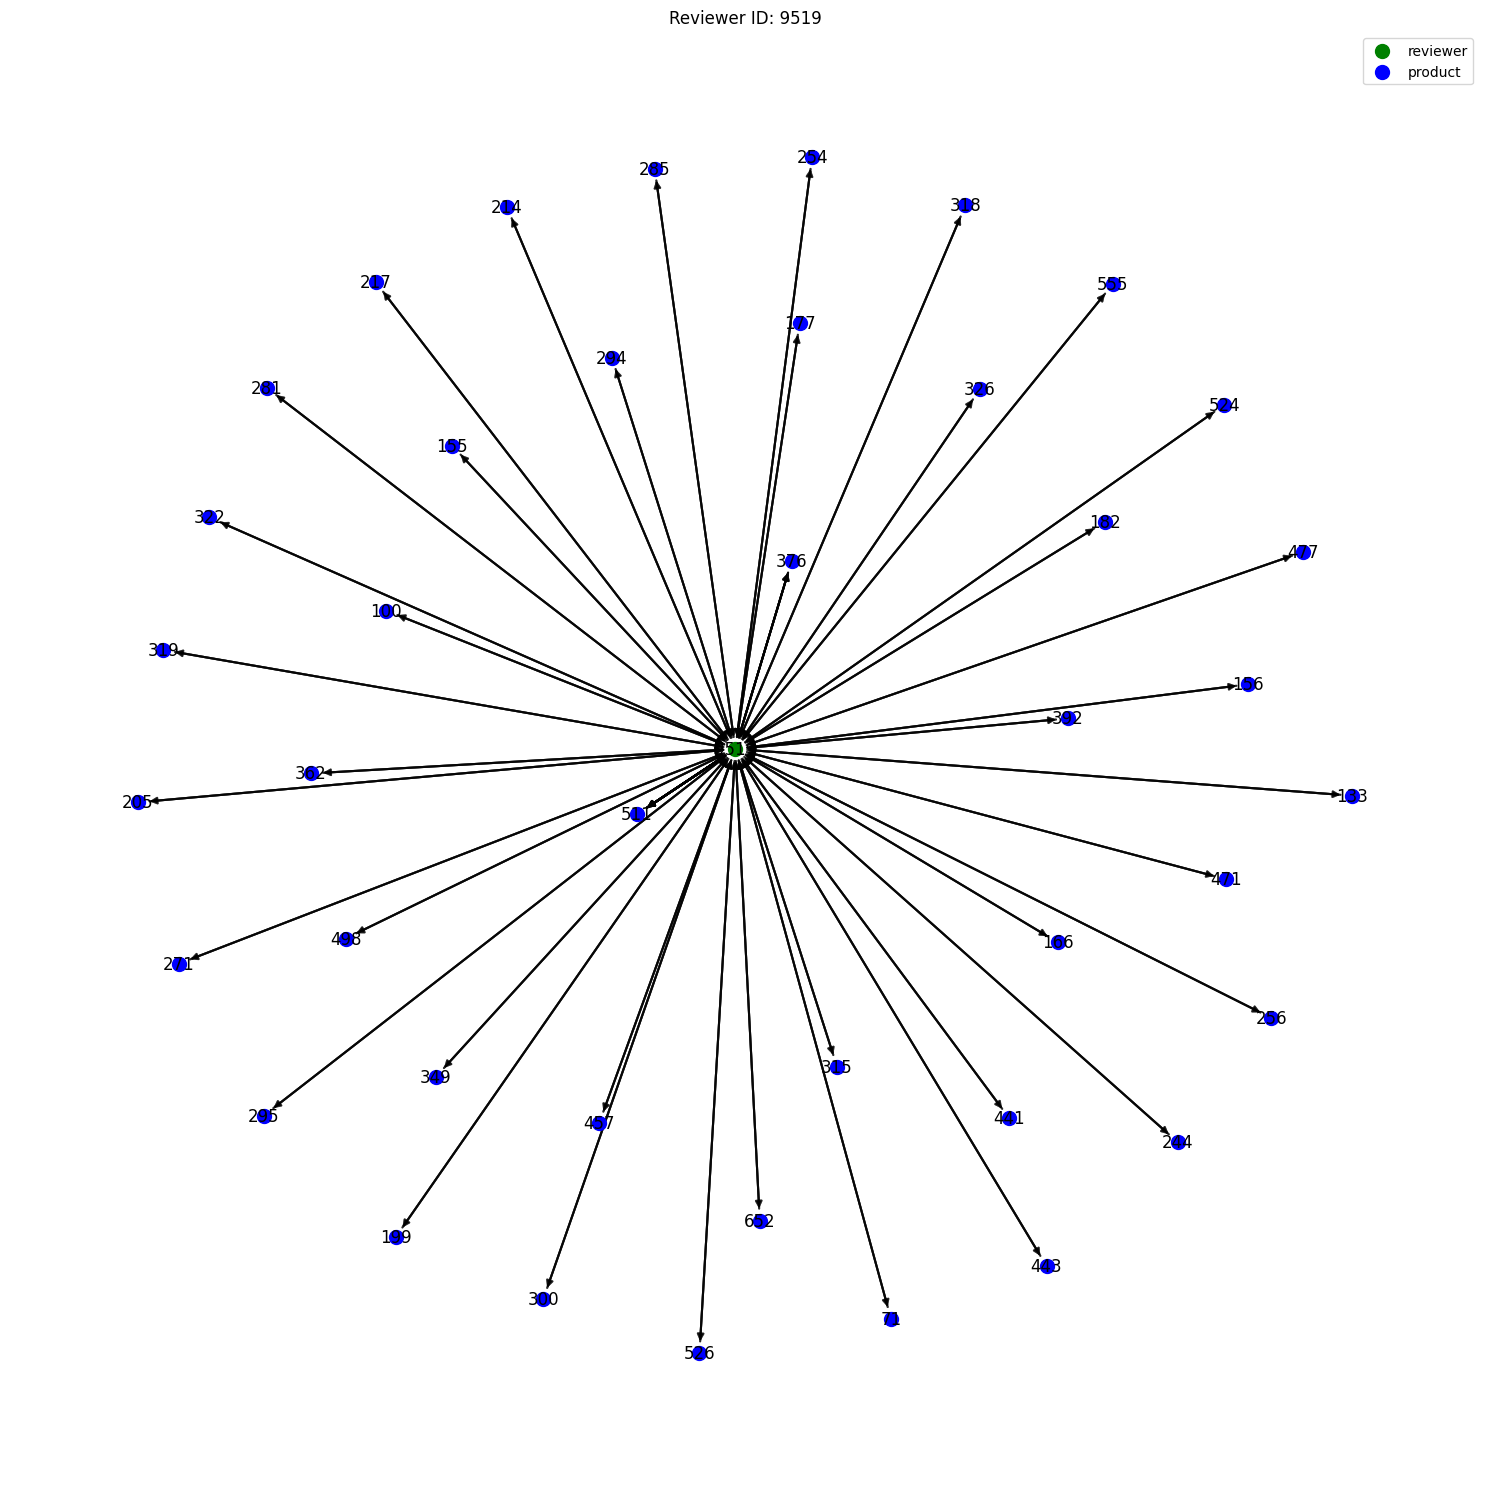

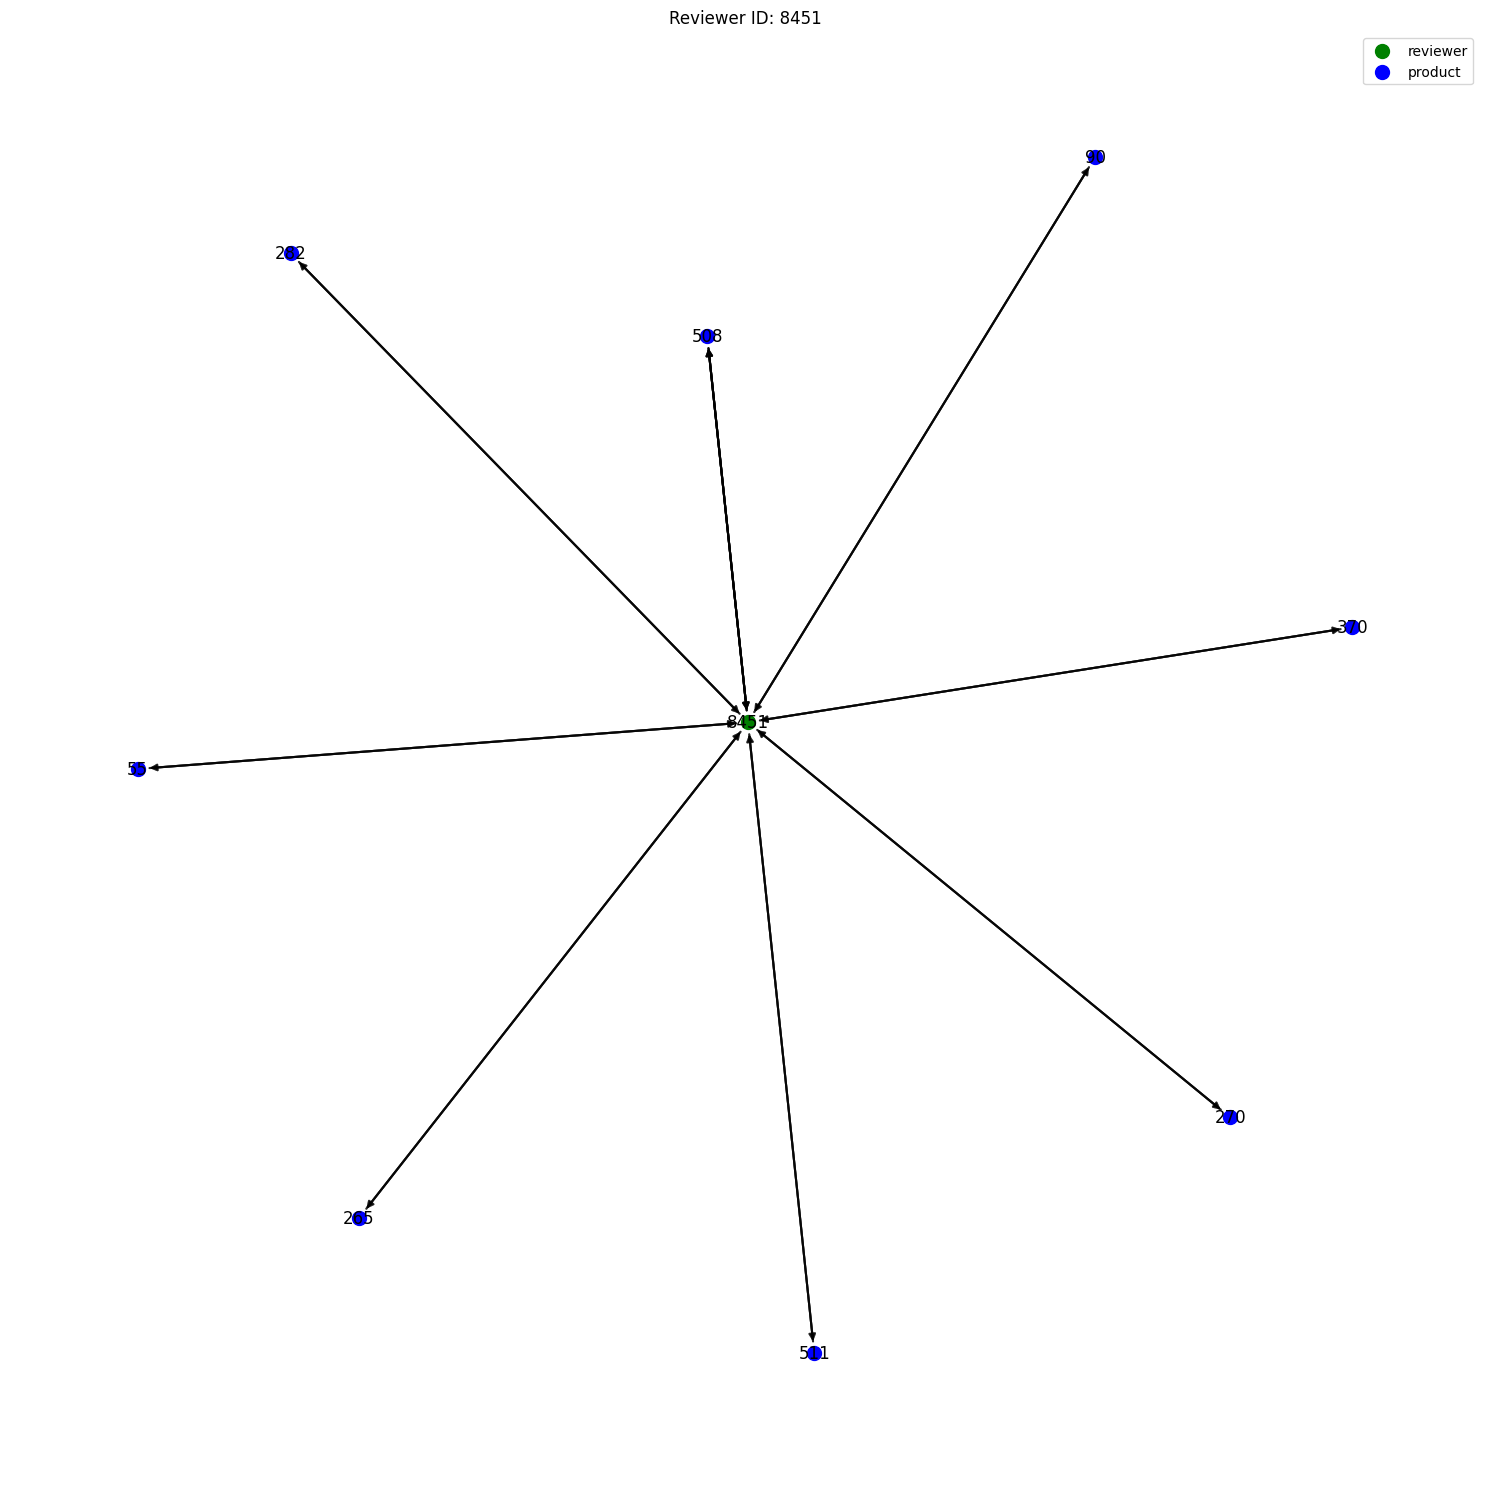

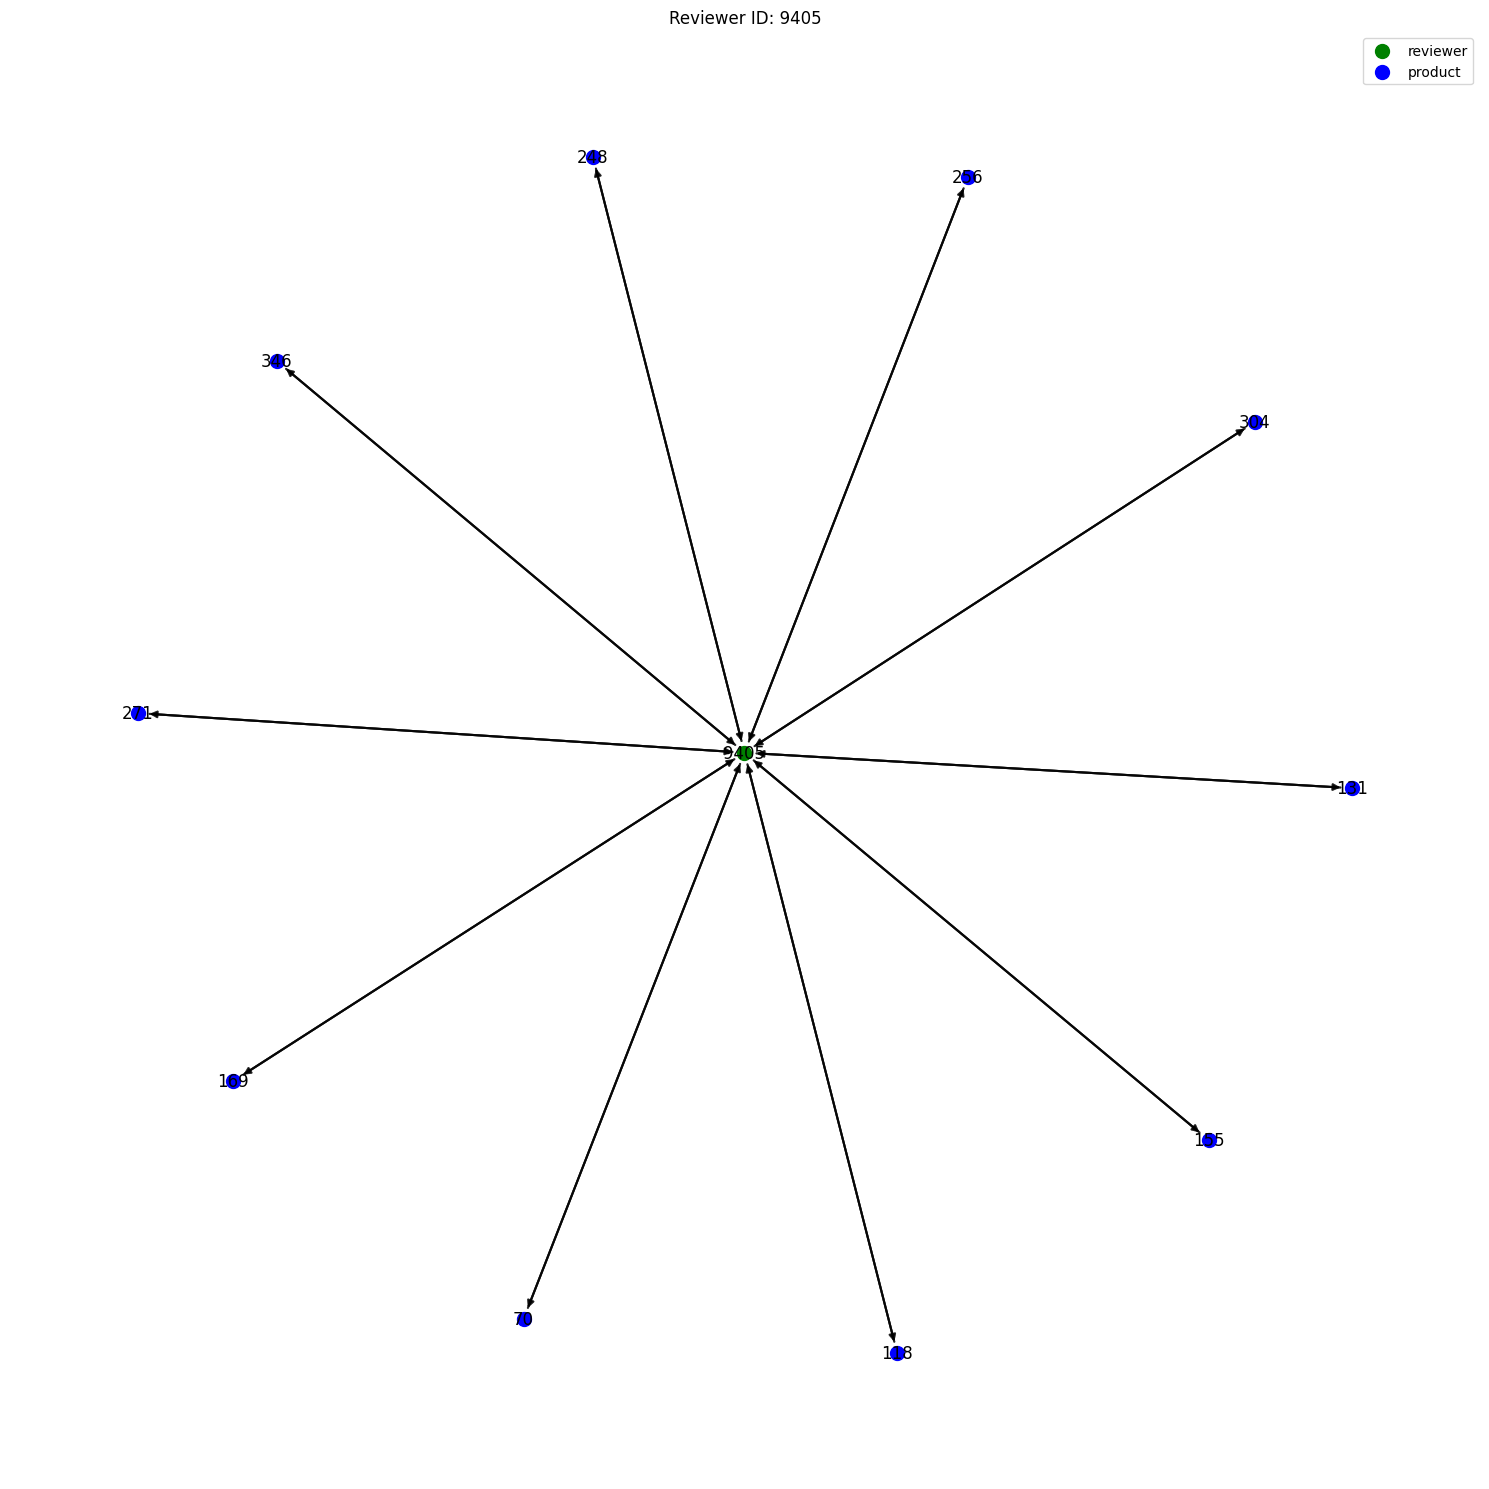

In [82]:
# Visualize reviewers connected to more than 3 products (limit to first 5 reviewers for demo purposes)
plot_reviewers_with_multiple_products(G, limit=3, min_products=8)